Individual assignment
===
1. Preprocessing
2. Sanity checks
3. First-level analysis

# 0. Setup

## Imports

In [1]:
from nipype.interfaces.spm.base import no_spm
no_spm()

True

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
from nipype import config

cfg = dict(
    logging=dict(workflow_level="INFO"),
    execution={
        "stop_on_first_crash": "True",
        "hash_method": "content",
        "remove_unnecessary_outputs": "True",
    },
)
config.update_config(cfg)

In [3]:
import os
from os.path import join as opj
import json
from nipype.interfaces.fsl import (
    BET,
    ExtractROI,
    FAST,
    FLIRT,
    ImageMaths,
    MCFLIRT,
    SliceTimer,
    Threshold,
    IsotropicSmooth,
    FLIRT,
    FNIRT,
    ApplyWarp,
)
from nipype.interfaces.fsl.utils import RobustFOV
import nibabel as nib
from nilearn import image, plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node
from IPython.display import Image

# Check if ENV variables are set
print("'FSLDIR':", os.environ["FSLDIR"])
print("'FSLOUTPUTTYPE':", os.environ["FSLOUTPUTTYPE"])

fslpath = os.environ["FSLDIR"]

# FSL
# os.environ["LD_LIBRARY_PATH"] = os.environ["LD_LIBRARY_PATH"] + os.pathsep + "/usr/lib/fsl/5.0"

# SPM
# os.environ["LD_LIBRARY_PATH"] = os.environ["LD_LIBRARY_PATH"] + os.pathsep + "/opt/mcr/" + os.environ["MCR_VERSION"] + "/runtime/glnxa64:/opt/mcr/" + os.environ["MCR_VERSION"] + "/bin/glnxa64:/opt/mcr/" + os.environ["MCR_VERSION"]  + "/sys/os/glnxa64:/opt/mcr/" + os.environ["MCR_VERSION"] + "/sys/opengl/lib/glnxa64:/opt/mcr/" + os.environ["MCR_VERSION"]  + "/extern/bin/glnxa64"

'FSLDIR': /opt/fsl-5.0.11
'FSLOUTPUTTYPE': NIFTI


In [4]:
os.environ["LD_LIBRARY_PATH"]

''

## Download data and MNI atlas

In [5]:
# sometimes it's necessary to update gdown
#!pip install gdown --upgrade
#!gdown 1YP7UtrbsFCCEYxvuY5D3DMiOh7pXyRWJ
#!unzip ./ds000102.zip -d ./data
#!rm ./ds000102.zip

In [6]:
os.path.exists("data/ds000102")

True

In [7]:
# add mni template to fsl dir
# os.makedirs(fslpath + "/data/standard", exist_ok=True)
# !wget 'https://ucloud.univie.ac.at/index.php/s/bnj6HPWqImlpFjD/download' -O mniatlas.zip
# !unzip -oq mniatlas.zip -d ${FSLDIR}/data/standard

In [8]:
mni_template = os.path.join(fslpath, "data/standard/MNI152_T1_2mm_brain.nii.gz")

os.path.exists(mni_template)

True

## Experiment parameters

In [9]:
project_root_dir = os.getcwd()
experiment_dir = project_root_dir + "/output"
output_dir = "datasink"
working_dir = "working_dir"
data_dir = project_root_dir + "/data/ds000102"

# list of subject identifiers
subject_list = ["02"]

# list of session identifiers
task_list = ["flanker"]

# Smoothing widths to apply
fwhm = [4]  # [4, 8]

# TR of functional images
with open(data_dir + "/task-flanker_bold.json", "rt") as fp:
    task_info = json.load(fp)
TR = task_info["RepetitionTime"]

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4


# os.environ["FSLOUTPUTTYPE"] = "NIFTI"

os.makedirs("data", exist_ok=True)
os.makedirs("output/working_dir", exist_ok=True)
os.makedirs(fslpath + "/data/standard", exist_ok=True)

### Inspect Data

In [10]:
anat = nib.load(
    f"{data_dir}/sub-{subject_list[0]}/anat/sub-{subject_list[0]}_T1w.nii.gz"
)
func = nib.load(
    f"{data_dir}/sub-{subject_list[0]}/func/sub-{subject_list[0]}_task-flanker_run-1_bold.nii.gz"
)

anat_data = anat.get_fdata()
func_data = func.get_fdata()  # [:, :, :, 4:]


# check the shape of the files
print("shape of anat file:", anat_data.shape)
print("shape of func file:", func_data.shape)

print(
    f"\nWe have {func_data.shape[2]} slices with a resolution of {func_data.shape[0]}x{func_data.shape[1]} voxels and {func_data.shape[3]} timepoints"
)

shape of anat file: (176, 256, 256)
shape of func file: (64, 64, 40, 146)

We have 40 slices with a resolution of 64x64 voxels and 146 timepoints


In [11]:
TA = TR - (TR / func_data.shape[2])
print(f"TA: {TA}\nTR: {TR}")

TA: 1.95
TR: 2.0


#### Plot of anatomical image

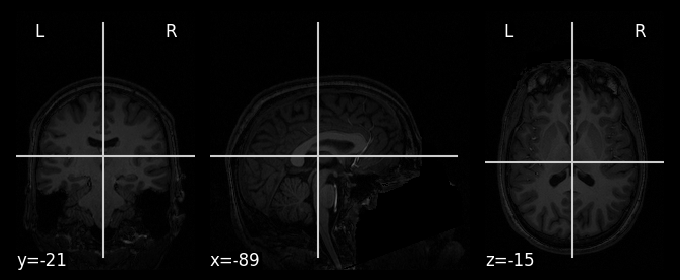

In [12]:
plotting.plot_anat(anat);

#### Plot of functional image

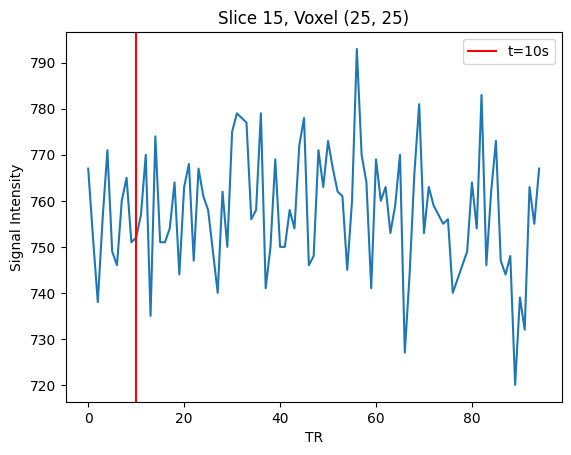

In [13]:
# define variables for number of slices, tr and ta

slice_no = 15
voxel_x = 25
voxel_y = 25

timepoints = slice(5, 100)
timepoint = 10

plt.plot(func_data[slice_no, voxel_x, voxel_y, timepoints])
plt.axvline(timepoint, color="red", label=f"t={timepoint}s")
plt.xlabel("TR")
plt.ylabel("Signal Intensity")
plt.title(f"Slice {slice_no}, Voxel {(voxel_x, voxel_y)}")
plt.legend();

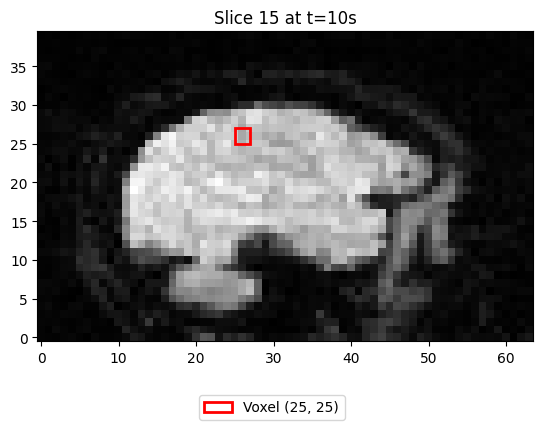

In [14]:
fig, ax = plt.subplots()
ax.imshow(func_data[slice_no, :, :, timepoint].T, cmap="gray", origin="lower")
rect = patches.Rectangle(
    (voxel_x, voxel_y),
    2,
    2,
    linewidth=2,
    edgecolor="r",
    facecolor="none",
    label=f"Voxel {(voxel_x, voxel_y)}",
)
ax.add_patch(rect)
ax.set_title(f"Slice {slice_no} at t={timepoint}s")
fig.legend(loc="lower center");

<div class="alert alert-info">everything looks alright</div>

# 1. Preprocessing

## Nodes for main workflow

In [15]:
# ExtractROI - remove first 4 volumes
# extract = Node(ExtractROI(t_min=4, t_size=-1, output_type="NIFTI"), name="extract")
extract = Node(
    ExtractROI(crop_list=[(0, -1), (0, -1), (0, -1), (4, -1)]), name="extract"
)  # alternative

# MCFLIRT - motion correction
realigner = Node(
    MCFLIRT(mean_vol=True, save_plots=True, output_type="NIFTI"), name="realigner"
)

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(
    SliceTimer(
        index_dir=False, interleaved=True, output_type="NIFTI", time_repetition=TR
    ),
    name="slicetimer",
)

# Smooth - image smoothing
smooth = Node(IsotropicSmooth(), name="smooth")
# smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(
    ArtifactDetect(
        norm_threshold=2,
        zintensity_threshold=3,
        mask_type="spm_global",
        parameter_source="FSL",
        use_differences=[True, False],
        plot_type="svg",
    ),
    name="art",
)

## Coregistration workflow

221215-17:37:34,63 nipype.workflow INFO:
	 Generated workflow graph: /main/assignments/Individual assignment/output/working_dir/coreg_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /main/assignments/Individual assignment/output/working_dir/coreg_wf/graph.png (graph2use=colored, simple_form=True).


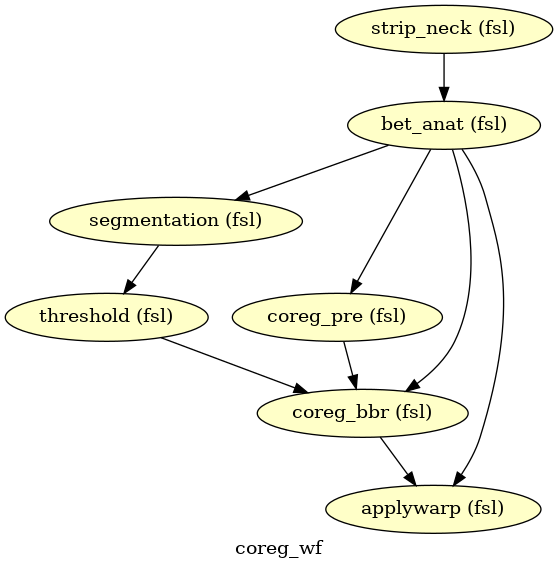

In [16]:
def create_fsl_coregflow(base_directory, apply_to_epis=False):
    """
    Creates FSL like coregistration worfklow

    Returns: Nipype Workflow object
    """

    coreg_wf = Workflow(name="coreg_wf", base_dir=base_directory)

    # Remove neck from anatomical image to improve skullstripping
    strip_neck = Node(RobustFOV(), name="strip_neck")

    # Skullstrip anatomical Image
    bet_anat = Node(
        BET(
            frac=0.2,
            # reduce_bias=True,
            output_type="NIFTI_GZ",
        ),
        name="bet_anat",
    )

    # T1 segmentation & bias field correction
    segmentation = Node(
        FAST(output_type="NIFTI_GZ", output_biascorrected=True),
        name="segmentation",
        mem_gb=4,
    )

    # Threshold WM probability image
    threshold = Node(
        Threshold(thresh=0.15, args="-bin", output_type="NIFTI_GZ"), name="threshold"
    )

    # Pre-alignment of functional images to anatomical images
    coreg_pre = Node(FLIRT(dof=6, output_type="NIFTI_GZ"), name="coreg_pre")

    # Use BBR cost function to improve the coregistration
    coreg_bbr = Node(
        FLIRT(
            dof=6,
            cost="bbr",
            schedule=os.path.join(os.getenv("FSLDIR"), "etc/flirtsch/bbr.sch"),
            output_type="NIFTI_GZ",
        ),
        name="coreg_bbr",
    )

    # Apply coregistration warp to functional images
    applywarp = Node(
        FLIRT(interp="spline", apply_isoxfm=4, output_type="NIFTI"), name="applywarp"
    )

    # connect nodes of coreg workflow
    coreg_wf.connect(
        [
            (strip_neck, bet_anat, [("out_roi", "in_file")]),
            (bet_anat, segmentation, [("out_file", "in_files")]),
            (segmentation, threshold, [(("partial_volume_files", get_wm), "in_file")]),
            (bet_anat, coreg_pre, [("out_file", "reference")]),
            (threshold, coreg_bbr, [("out_file", "wm_seg")]),
            (coreg_pre, coreg_bbr, [("out_matrix_file", "in_matrix_file")]),
            (bet_anat, coreg_bbr, [("out_file", "reference")]),
        ]
    )

    if apply_to_epis:
        coreg_wf.connect(coreg_bbr, "out_matrix_file", applywarp, "in_matrix_file")
        coreg_wf.connect(bet_anat, "out_file", applywarp, "reference")

    return coreg_wf


def get_wm(files):
    """
    Helper function to select WM segmentation file from segmentation output
    """
    return files[-1]


coreg_wf = create_fsl_coregflow(
    base_directory=opj(experiment_dir, working_dir), apply_to_epis=True
)

coreg_wf.write_graph(graph2use="colored", format="png", simple_form=True)
Image(filename=opj(coreg_wf.base_dir, "coreg_wf", "graph.png"))

## Normalization workflow

221215-17:37:34,548 nipype.workflow INFO:
	 Generated workflow graph: /main/assignments/Individual assignment/output/working_dir/norm_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /main/assignments/Individual assignment/output/working_dir/norm_wf/graph.png (graph2use=colored, simple_form=True).


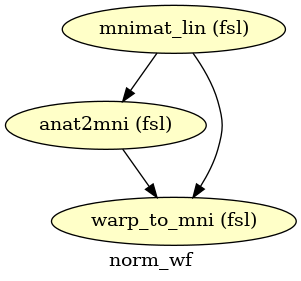

In [17]:
def create_fsl_normflow(base_directory, reference):
    """
    Creates FSL like normalization worfklow

    Returns: Nipype Workflow object
    """

    norm_wf = Workflow(name="norm_wf", base_dir=base_directory)

    # linear transformation of t1 to mni template
    mnimat_lin = Node(
        FLIRT(cost_func="normcorr", dof=12, reference=reference), name="mnimat_lin"
    )

    # non-linear transformation of t1 to mni (using params from linear transf.)
    anat2mni = Node(
        FNIRT(ref_file=reference, warped_file="warped.nii"), name="anat2mni"
    )

    # warp epi data to mni template
    warp_to_mni = Node(ApplyWarp(ref_file=reference), name="warp_to_mni")

    norm_wf.connect(
        [
            (mnimat_lin, anat2mni, [("out_matrix_file", "affine_file")]),
            (anat2mni, warp_to_mni, [("field_file", "field_file")]),
            (mnimat_lin, warp_to_mni, [("out_matrix_file", "postmat")]),
        ]
    )

    return norm_wf


norm_wf = create_fsl_normflow(
    base_directory=opj(experiment_dir, working_dir), reference=mni_template
)

norm_wf.write_graph(graph2use="colored", format="png", simple_form=True)
Image(filename=opj(norm_wf.base_dir, "norm_wf", "graph.png"))

## IO stream

In [18]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(
    IdentityInterface(fields=["subject_id", "task_name"]), name="infosource"
)
infosource.iterables = [("subject_id", subject_list), ("task_name", task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj(
    "sub-{subject_id}",
    "anat",
    "sub-{subject_id}_T1w.nii.gz",
)
func_file = opj(
    "sub-{subject_id}",
    "func",
    "sub-{subject_id}_task-{task_name}_run-1_bold.nii.gz",
)

templates = {"anat": anat_file, "func": func_file}
selectfiles = Node(SelectFiles(templates, base_directory=data_dir), name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(
    DataSink(base_directory=experiment_dir, container=output_dir), name="datasink"
)

## Use the following DataSink output substitutions
substitutions = [
    ("_subject_id_", "sub-"),
    ("_task_name_", "/task-"),
    ("_fwhm_", "fwhm-"),
    ("_roi", ""),
    ("_mcf", ""),
    ("_st", ""),
    ("_flirt", ""),
    (".nii_mean_reg", "_mean"),
    (".nii.par", ".par"),
]
subjFolders = [("fwhm-%s/" % f, "fwhm-%s_" % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Connect main workflow

In [19]:
# Create a preprocessing workflow
preproc_wf = Workflow(name="preproc_wf")
preproc_wf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc_wf.connect(
    [
        (
            infosource,
            selectfiles,
            [("subject_id", "subject_id"), ("task_name", "task_name")],
        ),
        (selectfiles, extract, [("func", "in_file")]),
        (extract, realigner, [("roi_file", "in_file")]),
        (realigner, slicetimer, [("out_file", "in_file")]),
        (
            selectfiles,
            coreg_wf,
            [
                ("anat", "strip_neck.in_file"),
            ],
        ),
        (
            realigner,
            coreg_wf,
            [
                ("mean_img", "coreg_pre.in_file"),
                ("mean_img", "coreg_bbr.in_file"),
            ],
        ),
        (
            slicetimer,
            coreg_wf,
            [("slice_time_corrected_file", "applywarp.in_file")],
        ),
        (
            coreg_wf,
            norm_wf,
            [
                ("segmentation.restored_image", "mnimat_lin.in_file"),
                ("segmentation.restored_image", "anat2mni.in_file"),
                ("applywarp.out_file", "warp_to_mni.in_file"),
            ],
        ),
        (norm_wf, smooth, [("warp_to_mni.out_file", "in_file")]),  # FSL
        # (norm_wf, smooth, [("warp_to_mni.out_file", "in_files")]),  # SPM
        (realigner, datasink, [("par_file", "preproc_wf.@par")]),
        (smooth, datasink, [("out_file", "preproc_wf.@smooth")]),  # FSL
        # (smooth, datasink, [("smoothed_files", "preproc_wf.@smooth")]),  # SPM
        (coreg_wf, art, [("applywarp.out_file", "realigned_files")]),
        (realigner, art, [("par_file", "realignment_parameters")]),
        (
            coreg_wf,
            datasink,
            [
                ("coreg_bbr.out_matrix_file", "preproc_wf.@mat_file"),
                ("bet_anat.out_file", "preproc_wf.@brain"),
            ],
        ),
        (
            norm_wf,
            datasink,
            [
                ("warp_to_mni.out_file", "preproc_wf.@warped_to_mni"),
                ("anat2mni.warped_file", "preproc_wf.@_file"),
            ],
        ),
        (
            art,
            datasink,
            [
                ("outlier_files", "preproc_wf.@outlier_files"),
                ("plot_files", "preproc_wf.@plot_files"),
            ],
        ),
    ]
)

## Visualize the complete workflow

221215-17:37:38,58 nipype.workflow INFO:
	 Generated workflow graph: /main/assignments/Individual assignment/output/working_dir/preproc_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /main/assignments/Individual assignment/output/working_dir/preproc_wf/graph.png (graph2use=colored, simple_form=True).


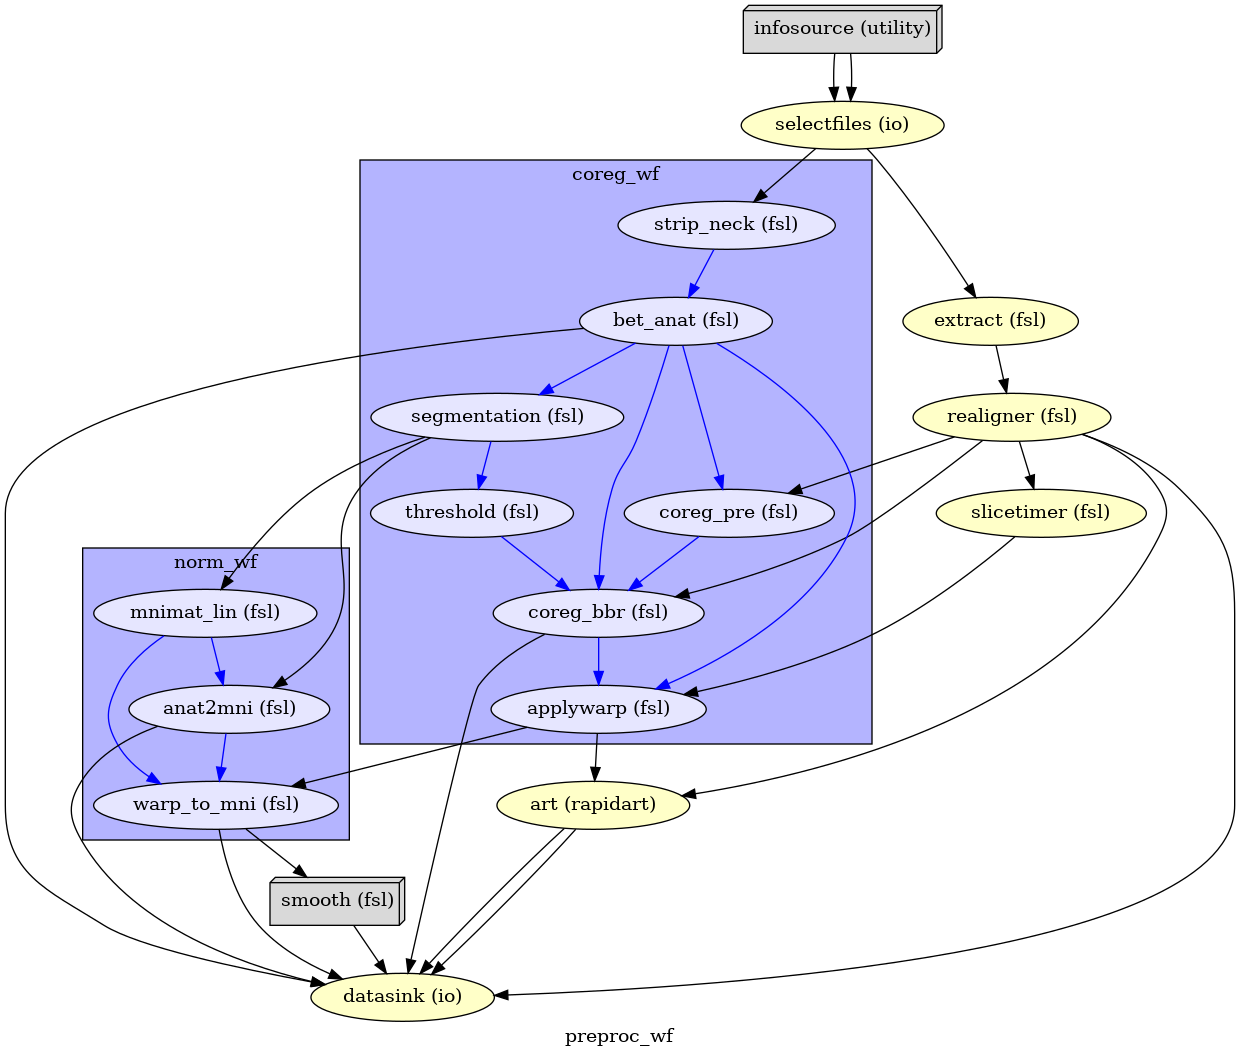

In [20]:
# Create preproc output graph
preproc_wf.write_graph(graph2use="colored", format="png", simple_form=True)

Image(filename=opj(preproc_wf.base_dir, "preproc_wf", "graph.png"))

221215-17:37:39,106 nipype.workflow INFO:
	 Generated workflow graph: /main/assignments/Individual assignment/output/working_dir/preproc_wf/graph.png (graph2use=flat, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /main/assignments/Individual assignment/output/working_dir/preproc_wf/graph.png (graph2use=flat, simple_form=True).


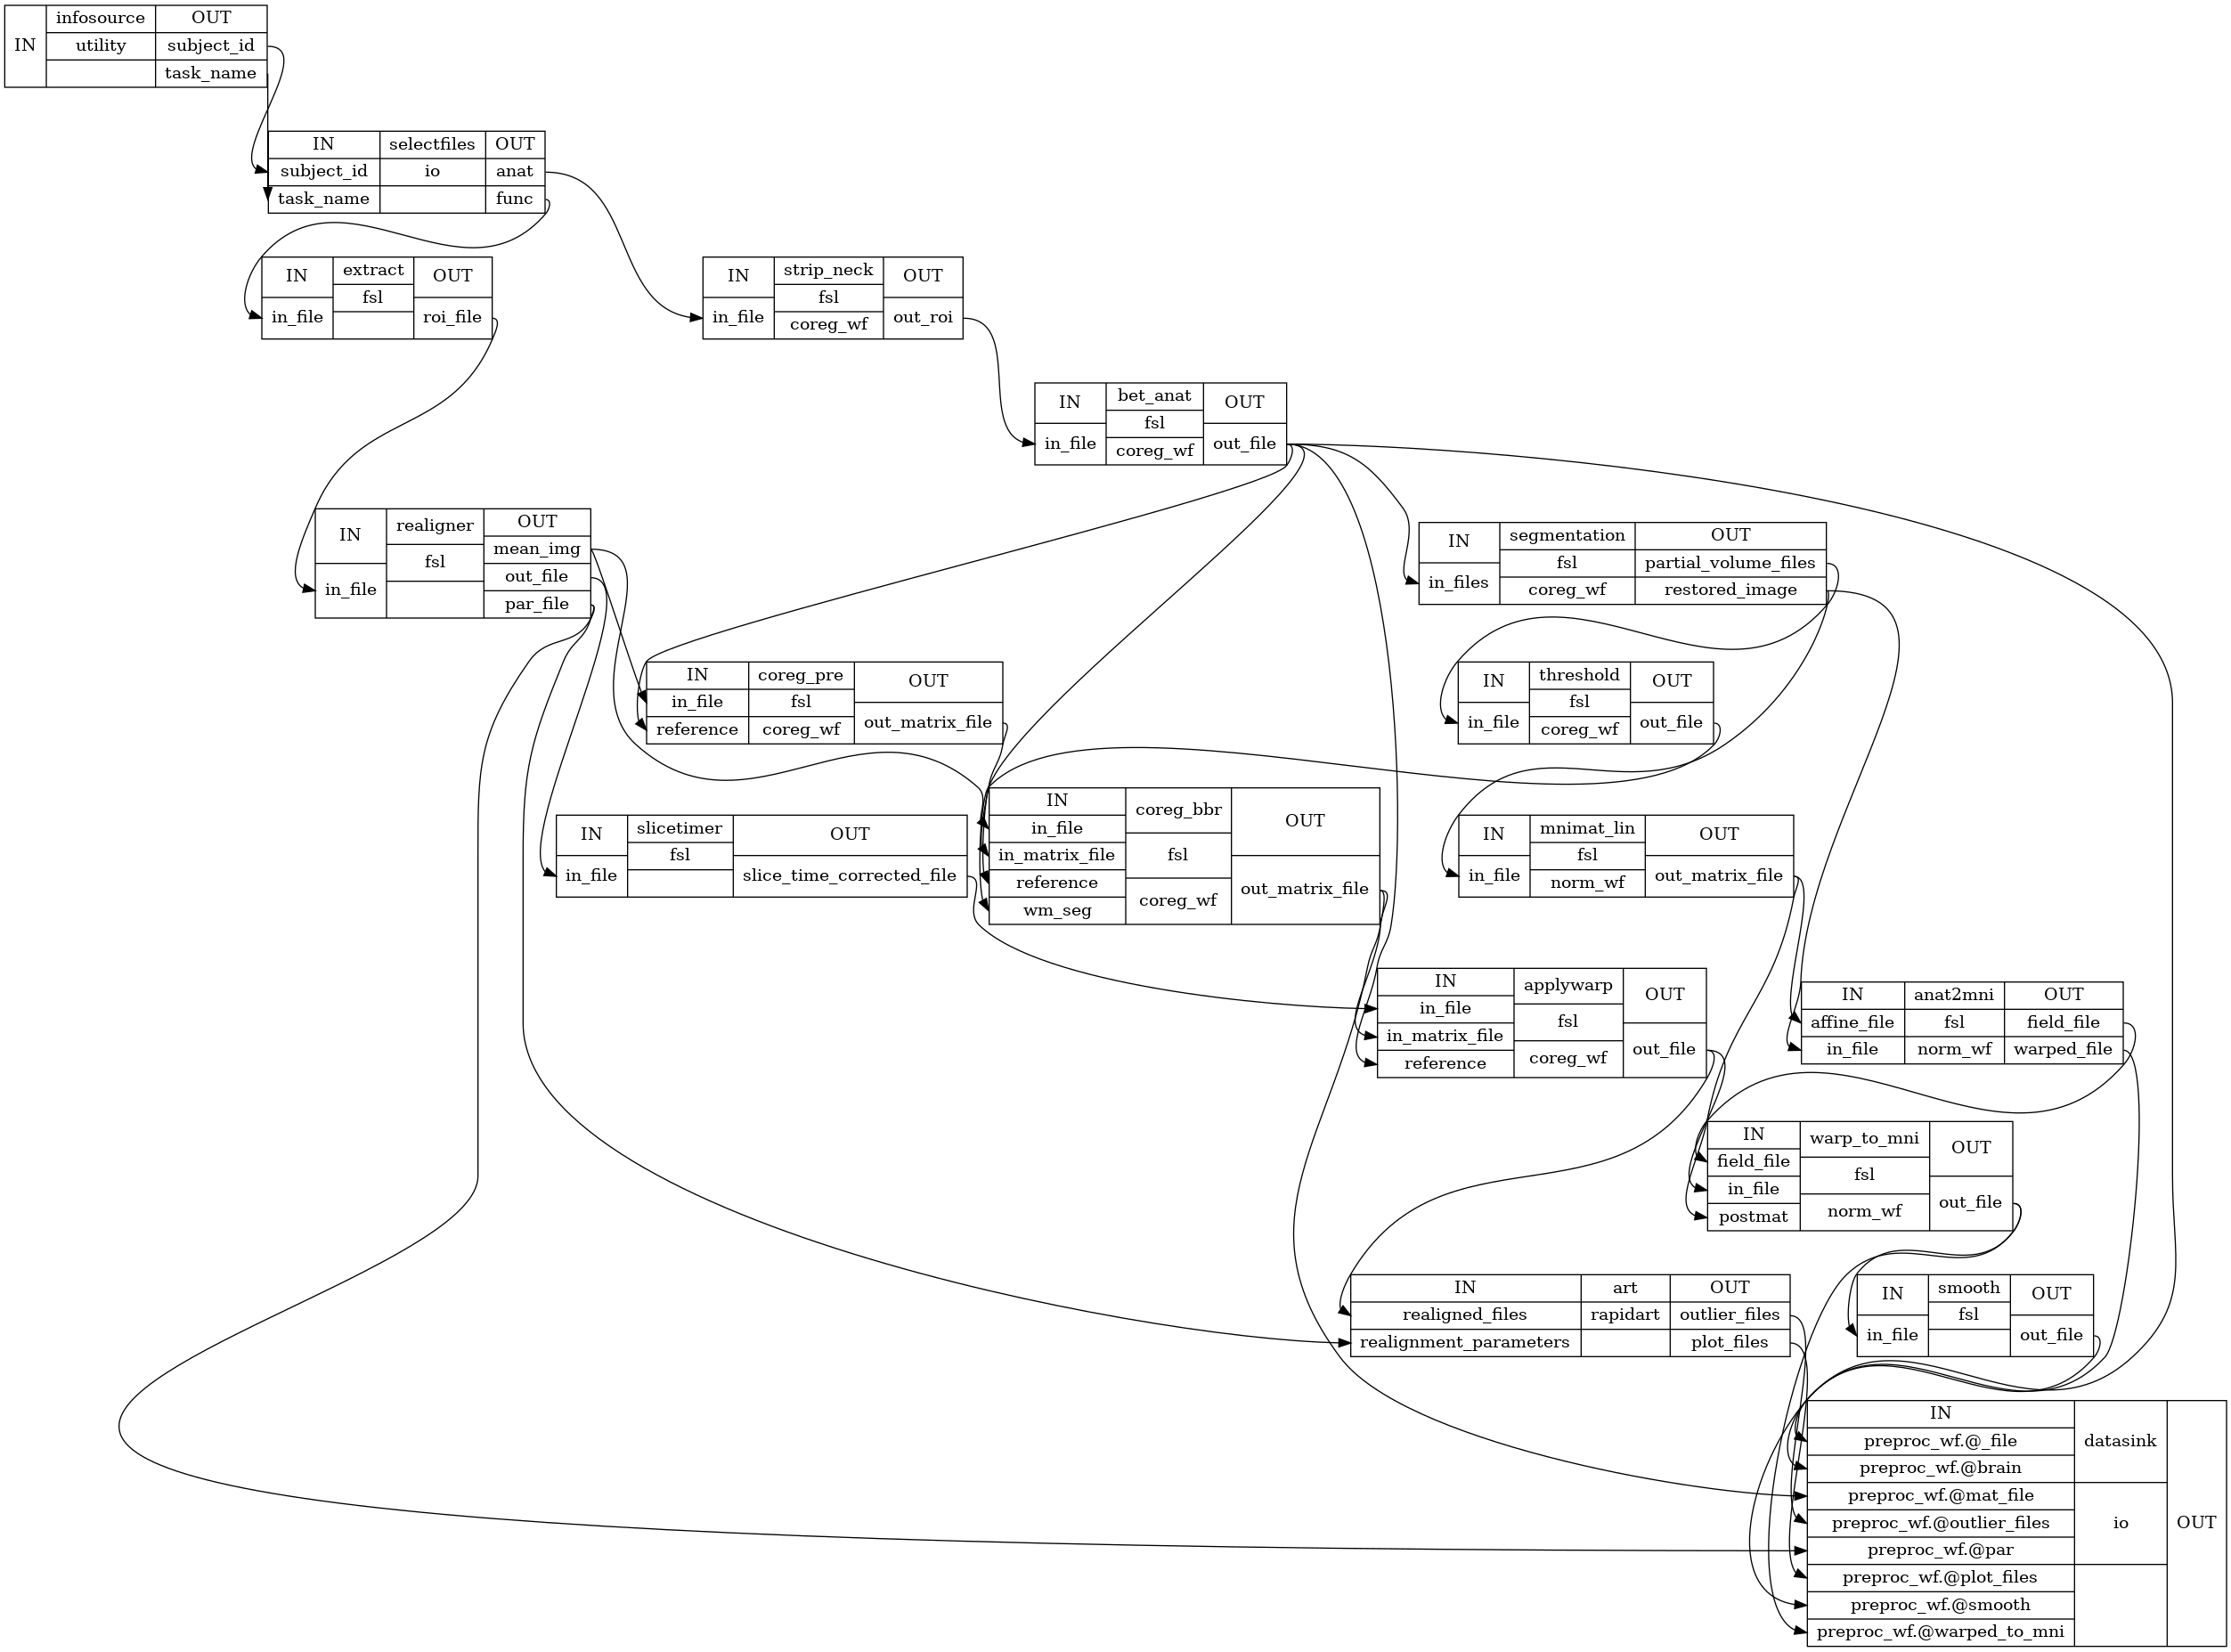

In [21]:
# Visualize the detailed graph
preproc_wf.write_graph(graph2use="flat", format="png", simple_form=True)
Image(filename=opj(preproc_wf.base_dir, "preproc_wf", "graph_detailed.png"))

## Run workflow

In [22]:
preproc_wf.run("MultiProc", plugin_args={"n_procs": 8})

221215-17:37:41,34 nipype.workflow INFO:
	 Workflow preproc_wf settings: ['check', 'execution', 'logging', 'monitoring']


INFO:nipype.workflow:Workflow preproc_wf settings: ['check', 'execution', 'logging', 'monitoring']


221215-17:37:41,69 nipype.workflow INFO:
	 Running in parallel.


INFO:nipype.workflow:Running in parallel.


221215-17:37:41,73 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221215-17:37:41,265 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.selectfiles" in "/main/assignments/Individual assignment/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/selectfiles".


INFO:nipype.workflow:[Node] Setting-up "preproc_wf.selectfiles" in "/main/assignments/Individual assignment/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/selectfiles".


221215-17:37:41,276 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


INFO:nipype.workflow:[Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


221215-17:37:41,282 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.001545s.


INFO:nipype.workflow:[Node] Finished "selectfiles", elapsed time 0.001545s.


221215-17:37:43,79 nipype.workflow INFO:
	 [Job 0] Completed (preproc_wf.selectfiles).


INFO:nipype.workflow:[Job 0] Completed (preproc_wf.selectfiles).


221215-17:37:43,85 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221215-17:37:43,222 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.extract" in "/main/assignments/Individual assignment/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/extract".
221215-17:37:43,222 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.coreg_wf.strip_neck" in "/main/assignments/Individual assignment/output/working_dir/preproc_wf/coreg_wf/_subject_id_02_task_name_flanker/strip_neck".


INFO:nipype.workflow:[Node] Setting-up "preproc_wf.extract" in "/main/assignments/Individual assignment/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/extract".
INFO:nipype.workflow:[Node] Setting-up "preproc_wf.coreg_wf.strip_neck" in "/main/assignments/Individual assignment/output/working_dir/preproc_wf/coreg_wf/_subject_id_02_task_name_flanker/strip_neck".


221215-17:37:43,287 nipype.workflow INFO:
	 [Node] Executing "strip_neck" <nipype.interfaces.fsl.utils.RobustFOV>


INFO:nipype.workflow:[Node] Executing "strip_neck" <nipype.interfaces.fsl.utils.RobustFOV>


221215-17:37:43,368 nipype.workflow INFO:
	 [Node] Executing "extract" <nipype.interfaces.fsl.utils.ExtractROI>


INFO:nipype.workflow:[Node] Executing "extract" <nipype.interfaces.fsl.utils.ExtractROI>


221215-17:37:43,560 nipype.workflow INFO:
	 [Node] Finished "strip_neck", elapsed time 0.268438s.


INFO:nipype.workflow:[Node] Finished "strip_neck", elapsed time 0.268438s.


221215-17:37:43,564 nipype.workflow WARNING:
	 Storing result file without outputs


221215-17:37:43,570 nipype.workflow WARNING:
	 [Node] Error on "preproc_wf.coreg_wf.strip_neck" (/main/assignments/Individual assignment/output/working_dir/preproc_wf/coreg_wf/_subject_id_02_task_name_flanker/strip_neck)


221215-17:37:43,577 nipype.workflow INFO:
	 [Node] Finished "extract", elapsed time 0.203151s.


INFO:nipype.workflow:[Node] Finished "extract", elapsed time 0.203151s.


221215-17:37:43,582 nipype.workflow WARNING:
	 Storing result file without outputs


221215-17:37:43,586 nipype.workflow WARNING:
	 [Node] Error on "preproc_wf.extract" (/main/assignments/Individual assignment/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/extract)


221215-17:37:45,80 nipype.workflow ERROR:
	 Node extract.b0 failed to run on host neuro-jupyter.


ERROR:nipype.workflow:Node extract.b0 failed to run on host neuro-jupyter.


221215-17:37:45,87 nipype.workflow ERROR:
	 Saving crash info to /main/assignments/Individual assignment/crash-20221215-173745-root-extract.b0-43bd4d01-70c7-4fbe-a9e5-40ea4ed2c88a.pklz
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)
nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node extract.

Cmdline:
	fslroi /main/assignments/Individual assignment/data/ds000102/sub-02/func/sub-0

ERROR:nipype.workflow:Saving crash info to /main/assignments/Individual assignment/crash-20221215-173745-root-extract.b0-43bd4d01-70c7-4fbe-a9e5-40ea4ed2c88a.pklz
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)
nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node extract.

Cmdline:
	fslroi /main/assignments/Individual assignment/data/ds000102/sub-02/func/sub-02_task-flanker_run-1_b

RuntimeError: Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
  File "/usr/local/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)
nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node extract.

Cmdline:
	fslroi /main/assignments/Individual assignment/data/ds000102/sub-02/func/sub-02_task-flanker_run-1_bold.nii.gz /main/assignments/Individual assignment/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/extract/sub-02_task-flanker_run-1_bold_roi.nii 0 -1 0 -1 0 -1 4 -1
Stdout:

	Usage: fslroi <input> <output> <xmin> <xsize> <ymin> <ysize> <zmin> <zsize>
	       fslroi <input> <output> <tmin> <tsize>

	       fslroi <input> <output> <xmin> <xsize> <ymin> <ysize> <zmin> <zsize> <tmin> <tsize>
	Note: indexing (in both time and space) starts with 0 not 1! Inputting -1 for a size will set it to the full image extent for that dimension.
Stderr:

Traceback:
	Traceback (most recent call last):
	  File "/usr/local/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 454, in aggregate_outputs
	    setattr(outputs, key, val)
	  File "/usr/local/lib/python3.9/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
	    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
	  File "/usr/local/lib/python3.9/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
	    self.error(objekt, name, str(value))
	  File "/usr/local/lib/python3.9/site-packages/traits/base_trait_handler.py", line 74, in error
	    raise TraitError(
	traits.trait_errors.TraitError: The 'roi_file' trait of an ExtractROIOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/main/assignments/Individual assignment/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/extract/sub-02_task-flanker_run-1_bold_roi.nii' <class 'str'> was specified.

	During handling of the above exception, another exception occurred:

	Traceback (most recent call last):
	  File "/usr/local/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 401, in run
	    outputs = self.aggregate_outputs(runtime)
	  File "/usr/local/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 461, in aggregate_outputs
	    raise FileNotFoundError(msg)
	FileNotFoundError: No such file or directory '/main/assignments/Individual assignment/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/extract/sub-02_task-flanker_run-1_bold_roi.nii' for output 'roi_file' of a ExtractROI interface



# 2. Sanity checks

## Inspect output

In [23]:
!tree output/datasink

output/datasink
└── preproc_wf
    └── sub-02
        └── task-flanker
            ├── art.sub-02_task-flanker_run-1_bold_outliers.txt
            ├── fwhm-4_sub-02_task-flanker_run-1_bold_warp_smooth.nii
            ├── plot.sub-02_task-flanker_run-1_bold.svg
            ├── sub-02_T1w_ROI_brain.nii.gz
            ├── sub-02_task-flanker_run-1_bold.par
            ├── sub-02_task-flanker_run-1_bold_mean.mat
            ├── sub-02_task-flanker_run-1_bold_warp.nii
            └── warped.nii

3 directories, 8 files


## Visualize results

Anatomical image

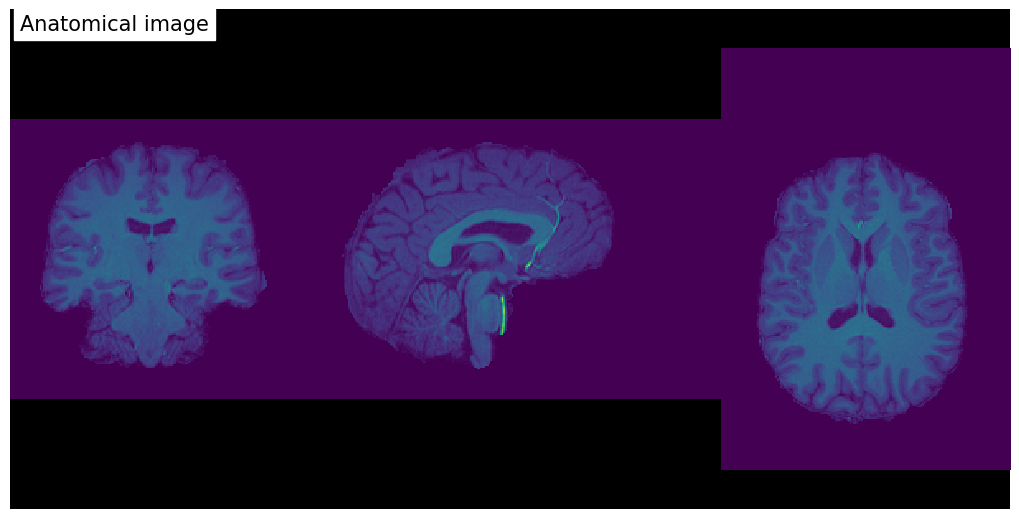

In [76]:
#%matplotlib inline
out_path = f"output/datasink/preproc_wf/sub-{subject_list[0]}/task-flanker"

fig = plt.figure(figsize=(10, 5))

plotting.plot_epi(
    opj(out_path, f"sub-{subject_list[0]}_T1w_ROI_brain.nii.gz"),
    title="Anatomical image",
    display_mode="ortho",
    annotate=False,
    draw_cross=False,
    cmap="viridis",
    figure=fig,
);

Functional image, Mean activation

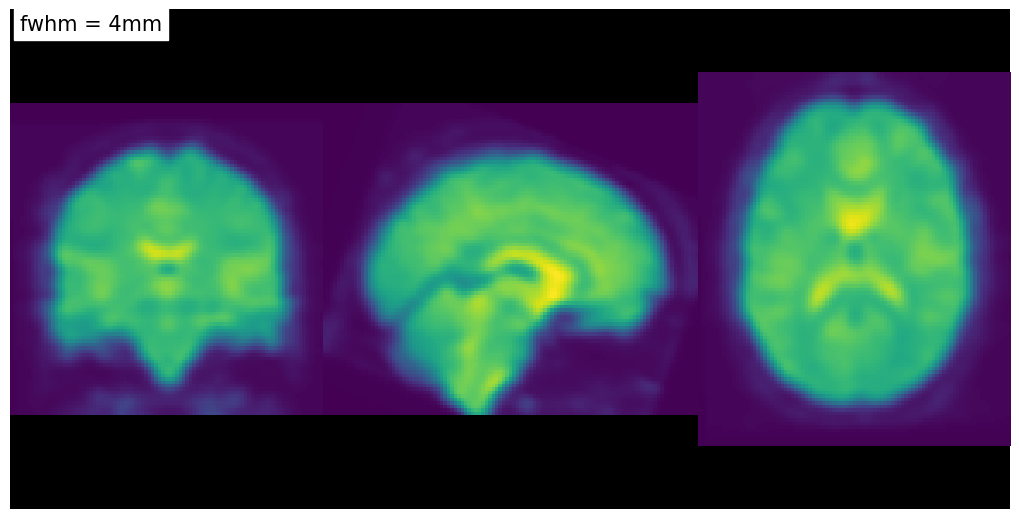

In [75]:
fig = plt.figure(figsize=(10, 5))

plotting.plot_epi(
    image.mean_img(
        opj(
            out_path,
            f"fwhm-4_sub-{subject_list[0]}_task-flanker_run-1_bold_warp_smooth.nii",
        )
    ),
    title="fwhm = 4mm",
    display_mode="ortho",
    annotate=False,
    draw_cross=False,
    cmap="viridis",
    figure=fig,
);

## Check shape of preprocessed image

In [26]:
pp_anat = nib.load(
    opj(out_path, f"sub-{subject_list[0]}_T1w_ROI_brain.nii.gz")
).get_fdata()

print(f"\n Shape of anatomical image: {pp_anat.shape}")


 Shape of anatomical image: (176, 256, 170)


In [27]:
pp_func = nib.load(
    opj(
        out_path,
        f"fwhm-4_sub-{subject_list[0]}_task-flanker_run-1_bold_warp_smooth.nii",
    )
).get_fdata()

print(f"\n Shape of functional image: {pp_func.shape}")


 Shape of functional image: (91, 109, 91, 142)


## Motion correction: Plot realignment parameters

Shape of motion parameter matrix: (142, 6)
[[-0.00444745  0.00195259  0.00047721  0.10688    -0.0317583  -0.155477  ]
 [-0.00374165  0.00262114  0.00078815  0.0880745  -0.0880255  -0.150471  ]
 [-0.00428458  0.00220039  0.00063716  0.0873345  -0.00687007 -0.170825  ]
 [-0.00455159  0.00220039  0.00076469  0.0664224  -0.0532908  -0.246671  ]
 [-0.00356772  0.0023792   0.00065857  0.065177   -0.0538013  -0.17929   ]]


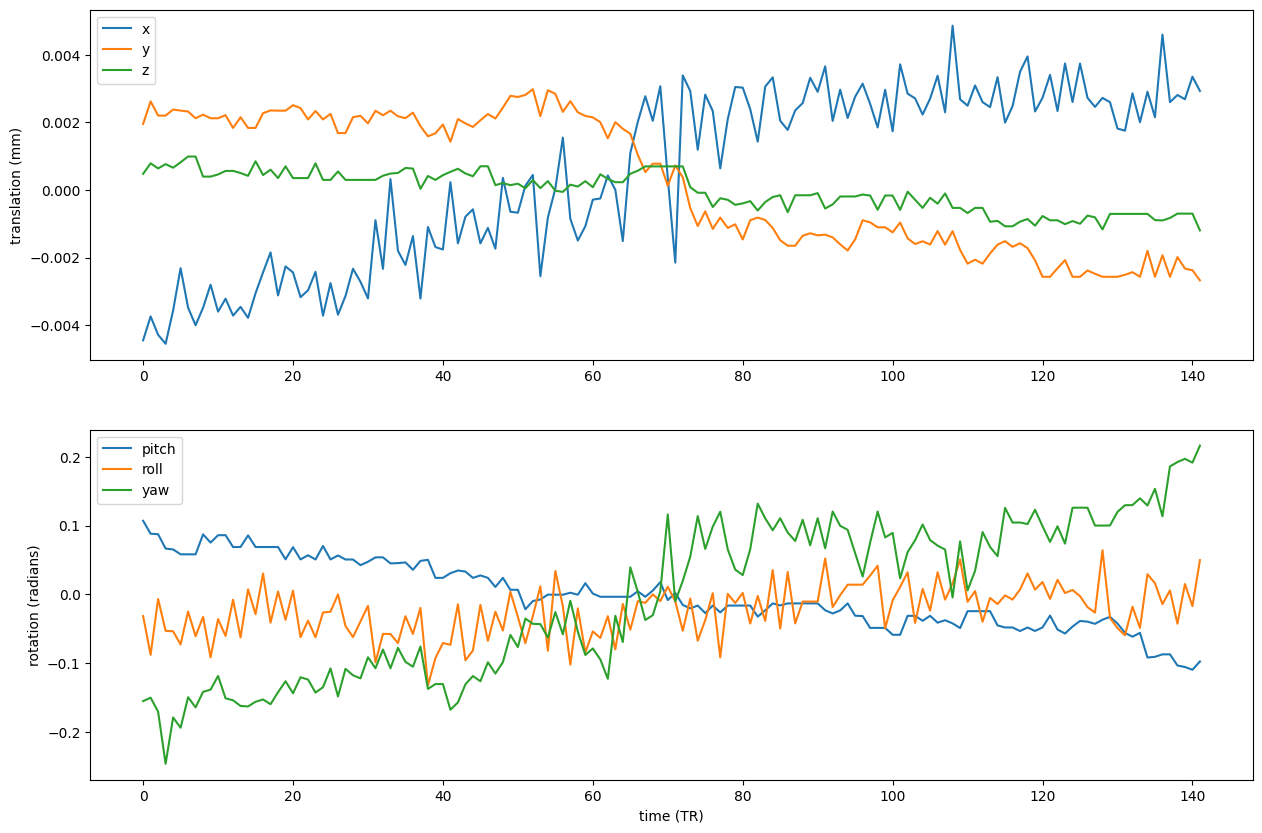

In [48]:
motion_parameters = np.loadtxt(
    f"output/datasink/preproc_wf/sub-{subject_list[0]}/task-flanker/sub-{subject_list[0]}_task-flanker_run-1_bold.par"
)

print(f"Shape of motion parameter matrix: {motion_parameters.shape}")
print(motion_parameters[:5, :])

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

axes[0].plot(motion_parameters[:, :3])
axes[1].plot(motion_parameters[:, 3:])

axes[0].set_ylabel("translation (mm)")
axes[1].set_ylabel("rotation (radians)")
axes[1].set_xlabel("time (TR)")

axes[0].legend(["x", "y", "z"])
axes[1].legend(["pitch", "roll", "yaw"]);

## Signal changes through the processing steps

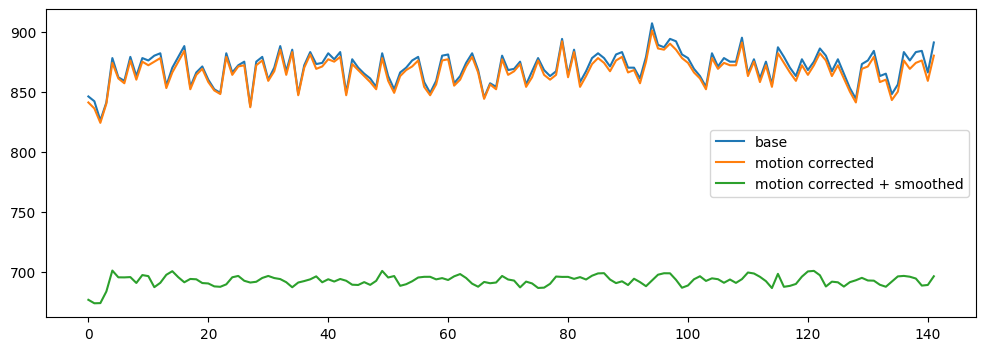

In [53]:
extract_data = nib.load(
    f"{experiment_dir}/{working_dir}/preproc_wf/_subject_id_{subject_list[0]}_task_name_flanker/extract/sub-{subject_list[0]}_task-flanker_run-1_bold_roi.nii"
)

mc_data = nib.load(
    f"{experiment_dir}/{working_dir}/preproc_wf/_subject_id_{subject_list[0]}_task_name_flanker/realigner/sub-{subject_list[0]}_task-flanker_run-1_bold_roi_mcf.nii"
)
smoothed_data = nib.load(
    f"{experiment_dir}/{working_dir}/preproc_wf/_subject_id_{subject_list[0]}_task_name_flanker/_fwhm_4/smooth/sub-{subject_list[0]}_task-flanker_run-1_bold_roi_mcf_st_flirt_warp_smooth.nii"
)

# A random voxel
x, y, z = 32, 34, 25
fig = plt.figure(figsize=(12, 4))
plt.plot(extract_data.get_fdata()[x, y, z, :])
plt.plot(mc_data.get_fdata()[x, y, z, :])
plt.plot(smoothed_data.get_fdata()[x, y, z, :])
# plt.plot(detrended_data.get_data()[x, y, z, :])
plt.legend(["base", "motion corrected", "motion corrected + smoothed"]);

## Check extraction

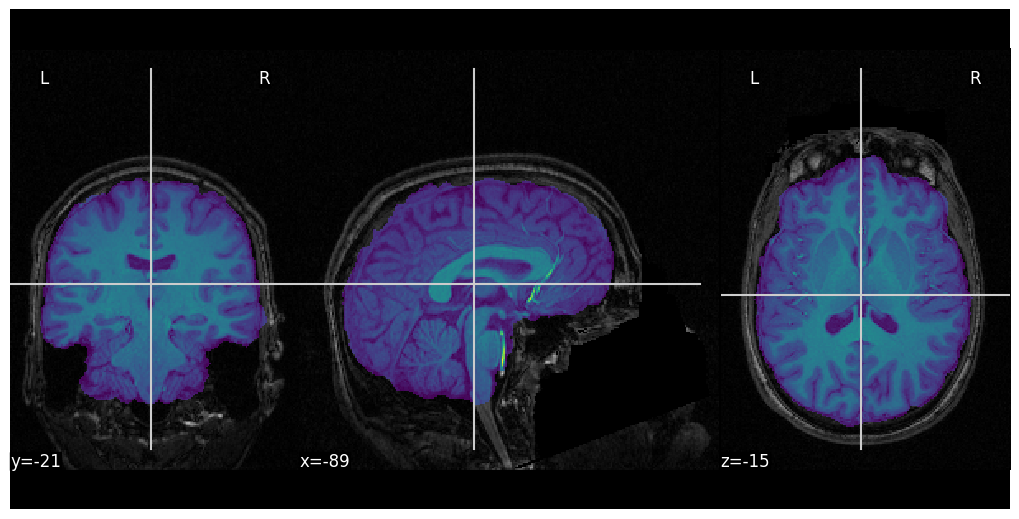

In [63]:
t1_raw = f"{data_dir}/sub-{subject_list[0]}/anat/sub-{subject_list[0]}_T1w.nii.gz"

fig = plt.figure(figsize=(10, 5))
disp_t1 = plotting.plot_anat(t1_raw, dim=-1, figure=fig)
disp_t1.add_overlay(
    f"{experiment_dir}/{output_dir}/preproc_wf/sub-{subject_list[0]}/task-flanker/sub-{subject_list[0]}_T1w_ROI_brain.nii.gz",
)

## Check normalization

### Raw image on mni template

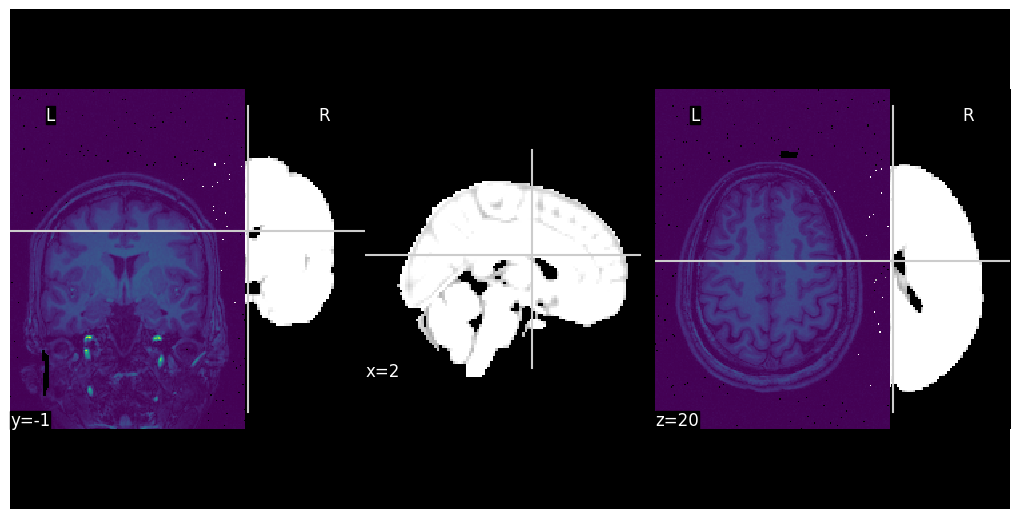

In [68]:
fig = plt.figure(figsize=(10, 5))
display = plotting.plot_anat(mni_template, dim=-1, figure=fig)
display.add_overlay(t1_raw)

### Normalized image on mni template

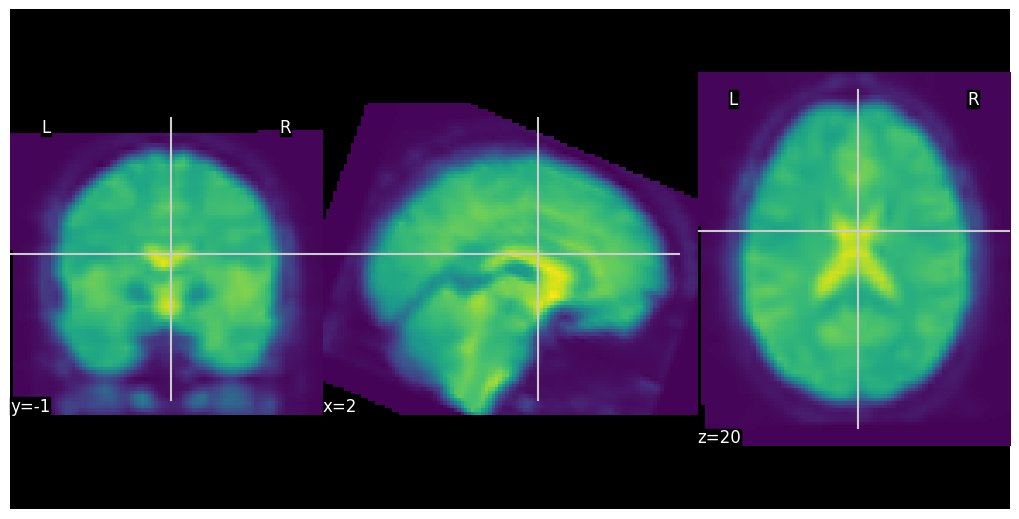

In [74]:
normalized_img = image.mean_img(
    f"{experiment_dir}/{working_dir}/preproc_wf/norm_wf/_subject_id_{subject_list[0]}_task_name_flanker/warp_to_mni/sub-{subject_list[0]}_task-flanker_run-1_bold_roi_mcf_st_flirt_warp.nii"
)

fig = plt.figure(figsize=(10, 5))
display = plotting.plot_anat(mni_template, dim=-1, figure=fig)
display.add_overlay(normalized_img)

# 3. First Level Analysis

In [83]:
import pandas as pd

participants = pd.read_table(f"{data_dir}/participants.tsv")

print(participants.loc[participants.participant_id == f"sub-{subject_list[0]}"])

  participant_id gender    age
1         sub-02      M  22.79


In [84]:
events = pd.read_table(
    f"{data_dir}/sub-{subject_list[0]}/func/sub-{subject_list[0]}_task-flanker_run-1_events.tsv"
)

events.head()

,onset,duration,trial_type,response_time,correctness,StimVar,Rsponse,Stimulus,cond
0,0.0,2.0,congruent_correct,0.510,correct,1,1,congruent,cond001
1,10.0,2.0,incongruent_correct,0.864,correct,2,1,incongruent,cond003
2,20.0,2.0,congruent_correct,0.540,correct,1,1,congruent,cond001
3,30.0,2.0,incongruent_correct,0.863,correct,2,1,incongruent,cond003
4,40.0,2.0,incongruent_correct,0.746,correct,2,1,incongruent,cond003


In [91]:
print(
    f"{len(events.trial_type.unique())} conditions:",
    events.trial_type.unique(),
    sep="\n",
)

2 conditions:
['congruent_correct' 'incongruent_correct']


In [93]:
import nibabel as nib

func = nib.load(
    opj(
        out_path,
        f"fwhm-4_sub-{subject_list[0]}_task-flanker_run-1_bold_warp_smooth.nii",
    )
)
print(func.shape)

(91, 109, 91, 142)


/usr/local/lib/python3.9/site-packages/nilearn/plotting/html_stat_map.py:219: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()
/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



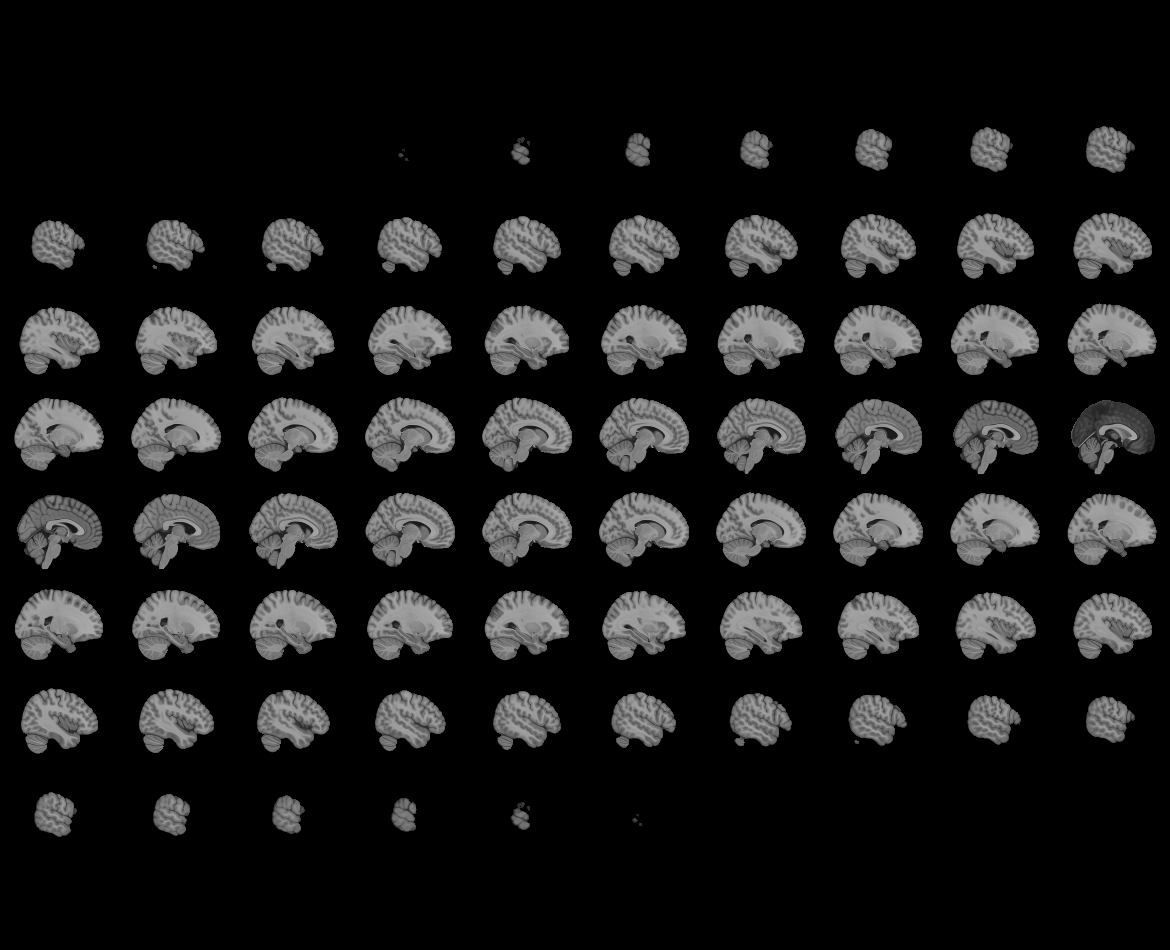
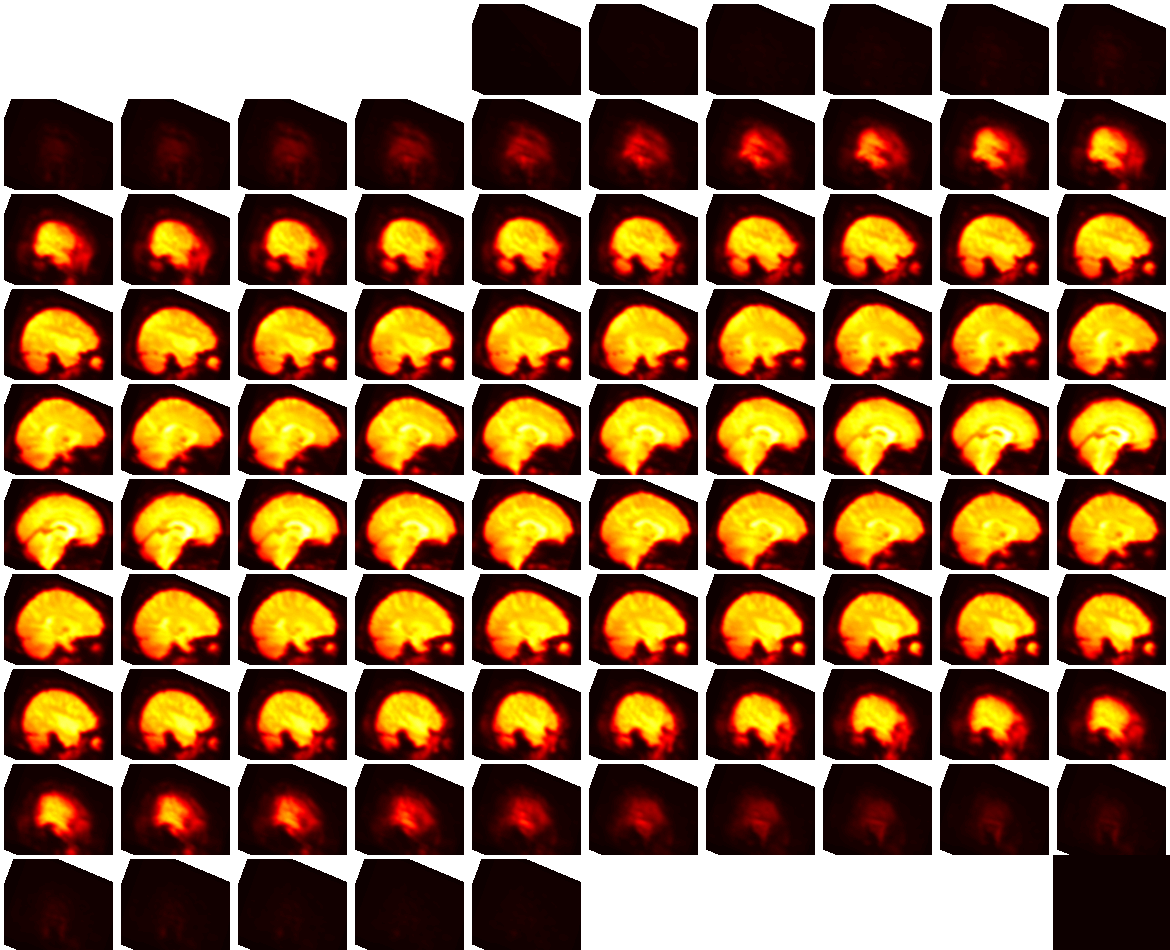

In [94]:
from nilearn import plotting, image

plotting.view_img(image.mean_img(func))

## Specifying model (GLM)

In [99]:
from nilearn.glm.first_level import FirstLevelModel


first_level = FirstLevelModel(
    t_r=TR,
    slice_time_ref=0,
    hrf_model="spm",
    high_pass=0.009,
    drift_model="cosine",
    minimize_memory=False,
)  # for voxelwise attributes like R-Squared)

## Fitting the model to the data

#### Load confounders (motion parameters)

In [107]:
confounds = pd.DataFrame(
    motion_parameters,
    columns=[
        "motion_x",
        "motion_y",
        "motion_z",
        "motion_pitch",
        "motion_roll",
        "motion_yaw",
    ],
)

confounds.head()

,motion_x,motion_y,motion_z,motion_pitch,motion_roll,motion_yaw
0,-0.004447,0.001953,0.000477,0.106880,-0.031758,-0.155477
1,-0.003742,0.002621,0.000788,0.088075,-0.088026,-0.150471
2,-0.004285,0.002200,0.000637,0.087334,-0.006870,-0.170825
3,-0.004552,0.002200,0.000765,0.066422,-0.053291,-0.246671
4,-0.003568,0.002379,0.000659,0.065177,-0.053801,-0.179290


In [109]:
first_level = first_level.fit(
    image.smooth_img(func, 4),
    events=events[["onset", "duration", "trial_type"]],
    confounds=confounds,
)  # 4, because our smoothing kernel had a width of 4

## Design matrix

Shape of design matrix: (142, 14)


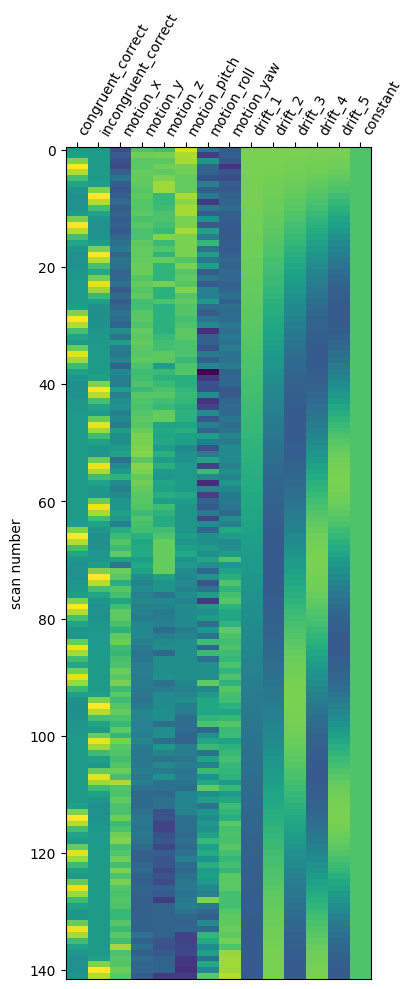

In [111]:
design_matrix = first_level.design_matrices_[0]
print("Shape of design matrix:", design_matrix.shape)
plotting.plot_design_matrix(design_matrix);

## Define contrasts

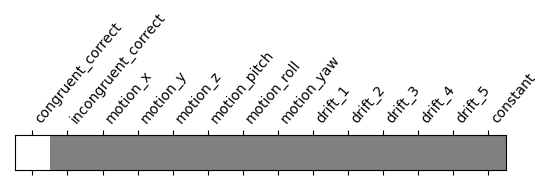

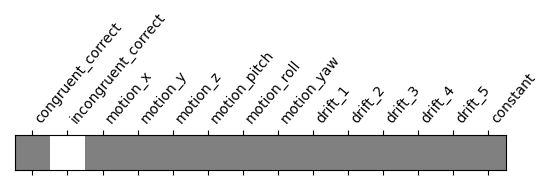

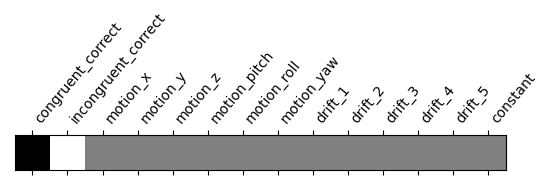

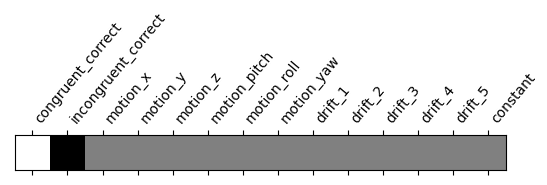

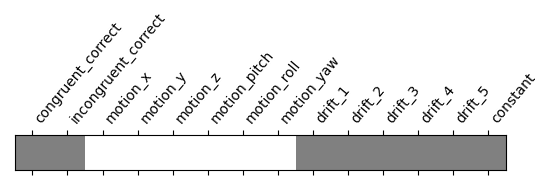

In [117]:
conditions = {
    "congruent_correct > baseline": np.array(
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ),
    "incongruent_correct > baseline": np.array(
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ),
    "incongruent-congruent": np.array([-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "congruent-incongruent": np.array([1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    "motion parameters > baseline": np.array(
        [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
    ),
}


for id, val in conditions.items():
    plotting.plot_contrast_matrix(val, design_matrix=design_matrix)

## Estimate contrasts

### Compute z-maps

In [124]:
z_map_congruent_baseline = first_level.compute_contrast(
    conditions["congruent_correct > baseline"], output_type="z_score"
)
z_map_incongruent_baseline = first_level.compute_contrast(
    conditions["incongruent_correct > baseline"], output_type="z_score"
)
z_map_incongruent_congruent = first_level.compute_contrast(
    conditions["incongruent-congruent"], output_type="z_score"
)
z_map_congruent_incongruent = first_level.compute_contrast(
    conditions["congruent-incongruent"], output_type="z_score"
)
z_map_motion_baseline = first_level.compute_contrast(
    conditions["motion parameters > baseline"], output_type="z_score"
)

### Plot z-maps

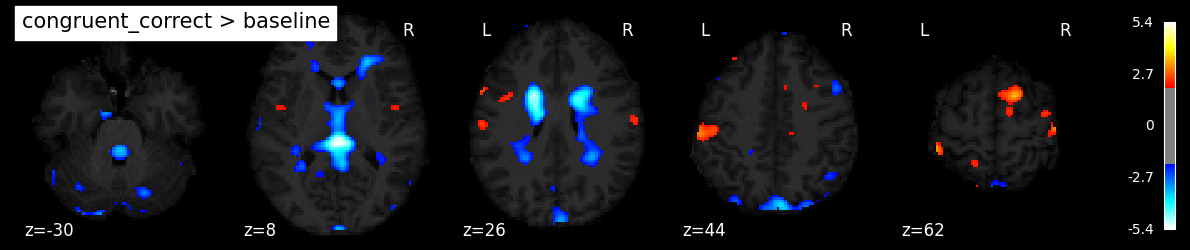

In [136]:
plotting.plot_stat_map(
    z_map_congruent_baseline,
    display_mode="z",
    cut_coords=5,
    threshold=2.0,
    title="congruent_correct > baseline",
    symmetric_cbar=True,
    bg_img=f"{experiment_dir}/{output_dir}/preproc_wf/sub-{subject_list[0]}/task-flanker/warped.nii",
)

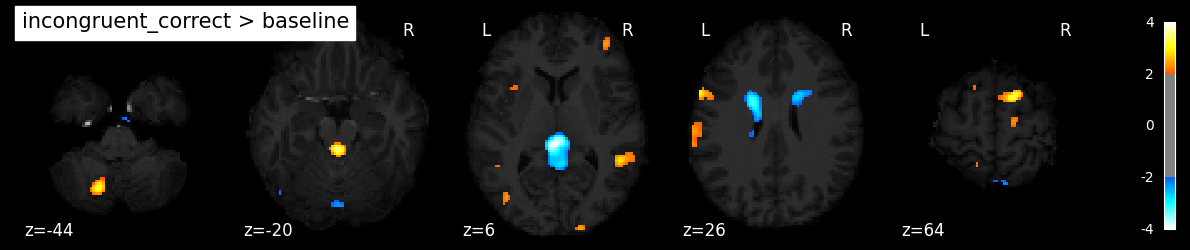

In [137]:
plotting.plot_stat_map(
    z_map_incongruent_baseline,
    display_mode="z",
    cut_coords=5,
    threshold=2.0,
    title="incongruent_correct > baseline",
    symmetric_cbar=True,
    bg_img=f"{experiment_dir}/{output_dir}/preproc_wf/sub-{subject_list[0]}/task-flanker/warped.nii",
)

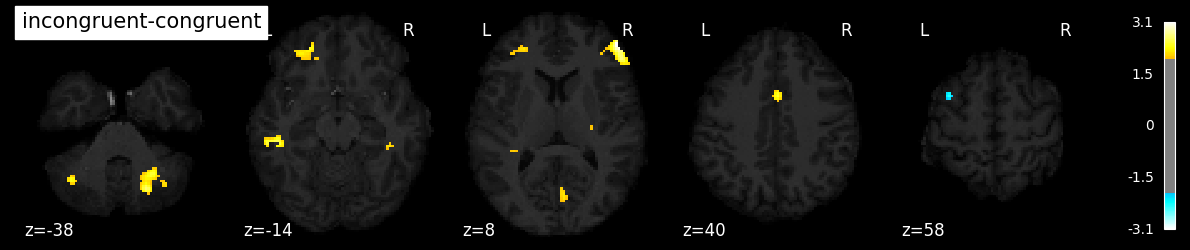

In [139]:
plotting.plot_stat_map(
    z_map_incongruent_congruent,
    display_mode="z",
    cut_coords=5,
    threshold=2.0,
    title="incongruent-congruent",
    symmetric_cbar=True,
    bg_img=f"{experiment_dir}/{output_dir}/preproc_wf/sub-{subject_list[0]}/task-flanker/warped.nii",
)

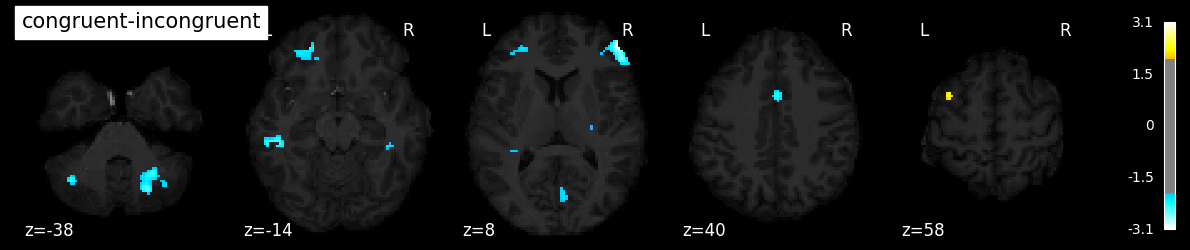

In [140]:
plotting.plot_stat_map(
    z_map_congruent_incongruent,
    display_mode="z",
    cut_coords=5,
    threshold=2.0,
    title="congruent-incongruent",
    symmetric_cbar=True,
    bg_img=f"{experiment_dir}/{output_dir}/preproc_wf/sub-{subject_list[0]}/task-flanker/warped.nii",
)

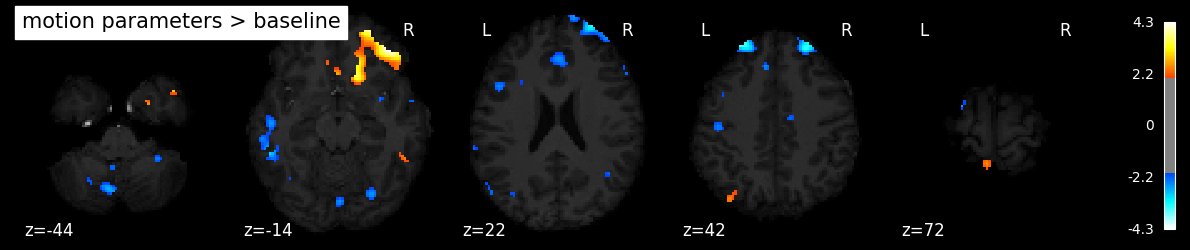

In [141]:
plotting.plot_stat_map(
    z_map_motion_baseline,
    display_mode="z",
    cut_coords=5,
    threshold=2.0,
    title="motion parameters > baseline",
    symmetric_cbar=True,
    bg_img=f"{experiment_dir}/{output_dir}/preproc_wf/sub-{subject_list[0]}/task-flanker/warped.nii",
)